開いているのはpysparkのshellなのでimport scとかはしない

In [1]:
# sparkの確認
sc

<SparkContext master=local[*] appName=PySparkShell>

## RDDの生成
RDD(Resilient Distributed Datasets)とはイミュータブルなJVMの分散コレクションから構成されているもの。RDDはスキーマレスなので色んなデータが混在してよい

In [2]:
poke = sc.parallelize([('ピカチュウ', 'でんき'), ('ギャラドス', 'みず', 'ひこう'), ('ガブリアス', [108, 130, 95, 80, 85, 102]), ['金銀', 251]])

RDDに対してtransoformationというRDDからRDDの変換とactionというRDDから別の形式への変換という操作が行える。操作の最適化を行うためにtransformationは遅延評価されactionが呼ばれるまで実行されない。
- transformationの例
    - .map()
    - .filter()
    - .leftOuterJoin()
- actionの例
    - .take()
    - .collect()
    - .reduce()

In [3]:
# データ確認
poke.collect()

[('ピカチュウ', 'でんき'),
 ('ギャラドス', 'みず', 'ひこう'),
 ('ガブリアス', [108, 130, 95, 80, 85, 102]),
 ['金銀', 251]]

In [4]:
# 先頭だけ抜き出す
poke.map(lambda x: x[0]).collect()

['ピカチュウ', 'ギャラドス', 'ガブリアス', '金銀']

.map()だけでは実行されない。.collect()でactionが呼ばれて初めて実行される

## 操作は並列で行われている

In [5]:
example = sc.parallelize([1, 2, 3, 4, 5, 6], 1) # 末尾の1はパーティションの数
example.reduce(lambda x, y: x - y) # 1 - 2 - 3 - 4 - 5 - 6

-19

In [6]:
example = sc.parallelize([1, 2, 3, 4, 5, 6], 3) # 末尾の1はパーティションの数
example.reduce(lambda x, y: x - y) # (1 - 2) - (3 - 4) - (5 - 6)

1

並列で操作しているためreduceなどで渡すoperatorは可換でないと想定している動作にならないことに注意。もちろん+とかなら想定通りの挙動をする

# DataFrame
実際にpysparkを扱う際はRDDを意識することなくDataFrameというものを用いてデータを扱う。DataFrameはpandasのDataFrameと同じようなものを考えて差支えない。DataFrameはRDDと違ってスキーマレスではない。

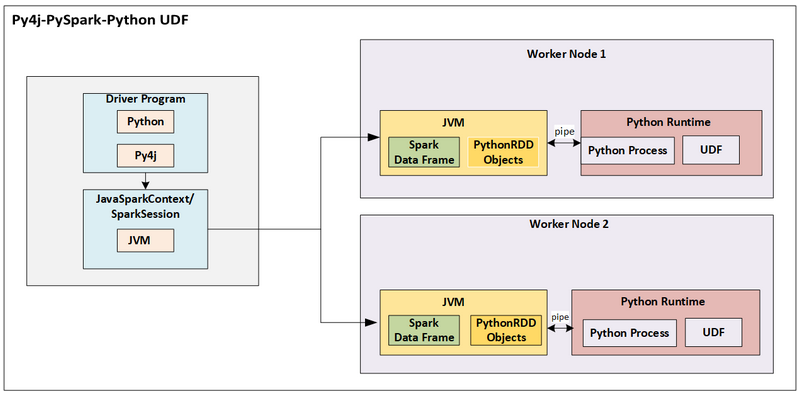

pythonでsparkを扱おうとすると上図 (https://dzone.com/articles/pyspark-java-udf-integration-1) のようにpythonとJVM(Java Virtual Machine)の通信のオーバーヘッドが重くscalaなどで扱ったときのパフォーマンスの半分もだせない。これを解決するのがDataFrame。なぜDataFrameを使うと早くなるのかは調べられていない...

## titanic
今回はtitanicのデータを扱う

### titanicのcolumnの説明
PassengerId: id

Survived: 生き残っているか

Pclass: チケットのクラス

Name: 名前

Sex: 性別

Age: 年齢

Siblings/Spouses Aboard: 兄弟配偶者の数

Parents/Children Aboard: 親子供の数

Ticket: ticket

Fare: 料金

Cabin: cabin

Embarked: どこから乗ったか C = Cherbourg, Q = Queenstown, S = Southampton

## RDDの生成

In [8]:
titanicRDD = sc.textFile('titanic.csv', 4)

## RDDからDataFrameの生成

In [11]:
titanicDF = spark.read.csv(titanicRDD, header='true', inferSchema='true')

In [12]:
# inferSchemaで推定したschemaの確認
titanicDF.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [14]:
# schemaを自分で与えることもできる
from pyspark.sql.types import *
schema = StructType([
    StructField('PassengerId', IntegerType(), True),
    StructField('Survived', IntegerType(), True),
    StructField('Pclass', IntegerType(), True),
    StructField('Name', StringType(), True),
    StructField('Sex', StringType(), True),
    StructField('Age', FloatType(), True),
    StructField('Sibsp', IntegerType(), True),
    StructField('Parch', IntegerType(), True),
    StructField('Ticket', StringType(), True),
    StructField('Fare', FloatType(), True),
    StructField('Cabin', StringType(), True),
    StructField('Embarked', StringType(), True)
])
titanicDF = spark.read.csv(titanicRDD, header='true', schema=schema)

In [15]:
titanicDF.printSchema()
# doubleからfloatになっている

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: float (nullable = true)
 |-- Sibsp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: float (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



### とりあえずデータ確認する
.take() or .show()でデータを確認できる。Pandasの.head()みたいな感じ。.collect()はすべてのデータを返すのでむやみやたらにに使うべきではない

In [16]:
titanicDF.take(5)

[Row(PassengerId=1, Survived=0, Pclass=3, Name='Braund, Mr. Owen Harris', Sex='male', Age=22.0, Sibsp=1, Parch=0, Ticket='A/5 21171', Fare=7.25, Cabin=None, Embarked='S'),
 Row(PassengerId=2, Survived=1, Pclass=1, Name='Cumings, Mrs. John Bradley (Florence Briggs Thayer)', Sex='female', Age=38.0, Sibsp=1, Parch=0, Ticket='PC 17599', Fare=71.2833023071289, Cabin='C85', Embarked='C'),
 Row(PassengerId=3, Survived=1, Pclass=3, Name='Heikkinen, Miss. Laina', Sex='female', Age=26.0, Sibsp=0, Parch=0, Ticket='STON/O2. 3101282', Fare=7.925000190734863, Cabin=None, Embarked='S'),
 Row(PassengerId=4, Survived=1, Pclass=1, Name='Futrelle, Mrs. Jacques Heath (Lily May Peel)', Sex='female', Age=35.0, Sibsp=1, Parch=0, Ticket='113803', Fare=53.099998474121094, Cabin='C123', Embarked='S'),
 Row(PassengerId=5, Survived=0, Pclass=3, Name='Allen, Mr. William Henry', Sex='male', Age=35.0, Sibsp=0, Parch=0, Ticket='373450', Fare=8.050000190734863, Cabin=None, Embarked='S')]

In [17]:
titanicDF.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|Sibsp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

### filter文

In [18]:
# Survivedな男性を抽出
titanicDF.filter('Survived == 1').filter('Sex == "male"').show(5)

+-----------+--------+------+--------------------+----+----+-----+-----+------+------+-----+--------+
|PassengerId|Survived|Pclass|                Name| Sex| Age|Sibsp|Parch|Ticket|  Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+----+----+-----+-----+------+------+-----+--------+
|         18|       1|     2|Williams, Mr. Cha...|male|null|    0|    0|244373|  13.0| null|       S|
|         22|       1|     2|Beesley, Mr. Lawr...|male|34.0|    0|    0|248698|  13.0|  D56|       S|
|         24|       1|     1|Sloper, Mr. Willi...|male|28.0|    0|    0|113788|  35.5|   A6|       S|
|         37|       1|     3|    Mamee, Mr. Hanna|male|null|    0|    0|  2677|7.2292| null|       C|
|         56|       1|     1|   Woolner, Mr. Hugh|male|null|    0|    0| 19947|  35.5|  C52|       S|
+-----------+--------+------+--------------------+----+----+-----+-----+------+------+-----+--------+
only showing top 5 rows



### count文

In [19]:
# 生存者を確認
titanicDF.filter('Survived == 1').count()

342

### describe文

In [20]:
# Fareのstatsを見る
titanicDF.describe('Fare').show()

+-------+-----------------+
|summary|             Fare|
+-------+-----------------+
|  count|              891|
|   mean|32.20420804114722|
| stddev|49.69342916316154|
|    min|              0.0|
|    max|         512.3292|
+-------+-----------------+



### groupby文

In [21]:
# チケットのクラス, 性別別の人数を見る
titanicDF.groupby(['Pclass', 'Sex']).count().show()

+------+------+-----+
|Pclass|   Sex|count|
+------+------+-----+
|     2|female|   76|
|     3|  male|  347|
|     1|  male|  122|
|     3|female|  144|
|     1|female|   94|
|     2|  male|  108|
+------+------+-----+



In [22]:
titanicDF.groupby(['Sex']).agg({'Fare': 'avg', 'Survived': 'avg'}).show()

+------+-------------------+------------------+
|   Sex|      avg(Survived)|         avg(Fare)|
+------+-------------------+------------------+
|female| 0.7420382165605095| 44.47981783690726|
|  male|0.18890814558058924|25.523893524910385|
+------+-------------------+------------------+



基本的にpandasと同じ感覚で使える。一覧は (https://spark.apache.org/docs/3.1.1/api/python/reference/pyspark.sql.html#dataframe-apis) のDataFreame APIを参照してください。

## SQLでのquery

In [23]:
# DataFrameからviewを作成
titanicDF.createOrReplaceTempView('titanicDF')

基本的にSQLがそのまま書ける

In [24]:
# Survivedな男性を抽出
spark.sql('SELECT * FROM titanicDF WHERE Survived = 1 AND Sex = "male"').show(5)

+-----------+--------+------+--------------------+----+----+-----+-----+------+------+-----+--------+
|PassengerId|Survived|Pclass|                Name| Sex| Age|Sibsp|Parch|Ticket|  Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+----+----+-----+-----+------+------+-----+--------+
|         18|       1|     2|Williams, Mr. Cha...|male|null|    0|    0|244373|  13.0| null|       S|
|         22|       1|     2|Beesley, Mr. Lawr...|male|34.0|    0|    0|248698|  13.0|  D56|       S|
|         24|       1|     1|Sloper, Mr. Willi...|male|28.0|    0|    0|113788|  35.5|   A6|       S|
|         37|       1|     3|    Mamee, Mr. Hanna|male|null|    0|    0|  2677|7.2292| null|       C|
|         56|       1|     1|   Woolner, Mr. Hugh|male|null|    0|    0| 19947|  35.5|  C52|       S|
+-----------+--------+------+--------------------+----+----+-----+-----+------+------+-----+--------+
only showing top 5 rows



In [25]:
# 末尾がyで終わる名前の人を抽出
spark.sql('SELECT * FROM titanicDF WHERE Name LIKE "%y"').show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|Sibsp|Parch|    Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------+-------+-----+--------+
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|    373450|   8.05| null|       S|
|         13|       0|     3|Saundercock, Mr. ...|  male|20.0|    0|    0| A/5. 2151|   8.05| null|       S|
|         57|       1|     2|   Rugg, Miss. Emily|female|21.0|    0|    0|C.A. 31026|   10.5| null|       S|
|         72|       0|     3|Goodwin, Miss. Li...|female|16.0|    5|    2|   CA 2144|   46.9| null|       S|
|        137|       1|     1|Newsom, Miss. Hel...|female|19.0|    0|    2|     11752|26.2833|  D47|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+----------+-------+-----+--------+
only showing top 5 

## MLのための前処理

### 重複の検出

In [26]:
# 全体の行数
print(f'Count of rows: {titanicDF.count()}')
# distinctな行数
print(f'Count of distinct rows: {titanicDF.distinct().count()}')

Count of rows: 891
Count of distinct rows: 891


In [ ]:
Row(PassengerId=2, Survived=1, Pclass=1, Name='Cumings, Mrs. John Bradley (Florence Briggs Thayer)', Sex='female', Age=38.0, Sibsp=1, Parch=0, Ticket='PC 17599', Fare=71.2833023071289, Cabin='C85', Embarked='C')

元データだと重複してないのでひとつ同じレコードを付け加える

In [33]:
addRow = [[2, 1, 1, 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)', 'female', 38.0, 1, 0, 'PC 17599', 71.2833023071289, 'C85', 'C']]
addDf = spark.createDataFrame(addRow)
titanicDF = titanicDF.union(addDf)

In [34]:
# 全体の行数
print(f'Count of rows: {titanicDF.count()}')
# distinctな行数
print(f'Count of distinct rows: {titanicDF.distinct().count()}')

Count of rows: 893
Count of distinct rows: 892


全体のレコードは892でdistinictなrowは891なので1つ重複している

In [35]:
# 重複しているrecordを除く
titanicDF = titanicDF.dropDuplicates()

In [36]:
# 全体の行数
print(f'Count of rows: {titanicDF.count()}')
# distinctな行数
print(f'Count of distinct rows: {titanicDF.distinct().count()}')

Count of rows: 892
Count of distinct rows: 892


全体のrecord数とdistinctなrecordの数が一致した

### IDを振る

In [38]:
import pyspark.sql.functions as fn
titanicDF.withColumn('id', fn.monotonically_increasing_id()).show(10)

+-----------+--------+------+--------------------+------+------------------+-----+-----+-------------+------------------+-------+--------+-----------+
|PassengerId|Survived|Pclass|                Name|   Sex|               Age|Sibsp|Parch|       Ticket|              Fare|  Cabin|Embarked|         id|
+-----------+--------+------+--------------------+------+------------------+-----+-----+-------------+------------------+-------+--------+-----------+
|        119|       0|     1|Baxter, Mr. Quigg...|  male|              24.0|    0|    1|     PC 17558| 247.5207977294922|B58 B60|       C|          0|
|        472|       0|     3|     Cacic, Mr. Luka|  male|              38.0|    0|    0|       315089| 8.662500381469727|   null|       S|          1|
|        535|       0|     3| Cacic, Miss. Marija|female|              30.0|    0|    0|       315084| 8.662500381469727|   null|       S|          2|
|        686|       0|     2|Laroche, Mr. Jose...|  male|              25.0|    1|    2|SC/Par

並列で処理されるのにuniqueなidが振れるの?って一瞬思うが10億以下のpartitionで80億以下のrecordの数の場合単調増加にidが振れることが保証されている。逆にそれ以上の場合はidがユニークであることは保証されない

### 欠損値の処理

In [49]:
# Cabinが欠損している数を求める
titanicDF.where(fn.col('Cabin').isNull()).count()

687

In [50]:
titanicDF.agg(titanicDF.where(fn.col('Cabin').isNull()).count()).show()

AssertionError: all exprs should be Column

In [54]:
titanicDF.select([fn.count(fn.when(fn.isnull(c), c)).alias(c) for c in titanicDF.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|Sibsp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [55]:
titanicDF.select([fn.count(fn.when(fn.isnull("Cabin"), 'Cabin')).alias('Cabin')]).show()

+-----+
|Cabin|
+-----+
|  687|
+-----+



In [56]:
[fn.count(fn.when(fn.isnull("Cabin"), 'Cabin')).alias('Cabin')]

[Column<'count(CASE WHEN (Cabin IS NULL) THEN Cabin END) AS `Cabin`'>]